# SubgraphX on BA-Shapes dataset for 2-layer GCN

Requires:
- conda create --name ml_project python=3.11.5
- conda activate ml_project
- pip install torch torchvision torchaudio
- pip install torch_geometric==2.2.0
- pip install dive-into-graphs
- pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

In [2]:
import os
import os.path as osp

import torch
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [3]:
dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

### Load model and checkpoints

In [4]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)


model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
from dig.xgraph.method import SubgraphX

explainer = SubgraphX(model, num_classes=4, device=device,
                      explain_graph=False, reward_method='nc_mc_l_shapley')

### Visualization

explain graph node 515
2


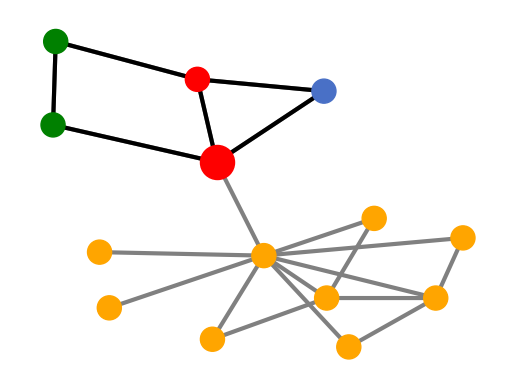

In [8]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()
print(prediction)

_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

### The metric result

In [7]:
max_nodes = 5
for node_idx in node_indices:
    index += 1
    print(f'explain graph node {node_idx}')
    data.to(device)

    if torch.isnan(data.y[0].squeeze()):
        continue

    logits = model(data.x, data.edge_index)
    prediction = logits[node_idx].argmax(-1).item()

    _, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

    explanation_results = explanation_results[prediction]
    explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)
    result = find_closest_node_result(explanation_results, max_nodes=max_nodes)

    x_collector.collect_data(result.coalition, related_preds, label=prediction)
    if index >= 20:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n',
      f'Infidelity: {x_collector.fidelity_inv:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

explain graph node 302
explain graph node 313
explain graph node 321
explain graph node 332
explain graph node 336
explain graph node 348
explain graph node 356
explain graph node 367
explain graph node 369
explain graph node 381
explain graph node 387
explain graph node 418
explain graph node 454
explain graph node 461
explain graph node 466
explain graph node 469
explain graph node 471
explain graph node 497
explain graph node 508
explain graph node 514
explain graph node 515
Fidelity: 0.7987
 Infidelity: 0.2341
Sparsity: 0.1818
